In [2]:
import os
import glob
import numpy as np
# method imports
import util
from algo import pdhg_tv
from cil.utilities.display import show2D

In [3]:
def preprocess(data):
    '''Preprocess the data'''
    # renormalise data
    data_renorm = util.correct_normalisation(data)
    # pad data
    data_pad = util.pad_zeros(data_renorm)
    # apply beam hardening correction
    data_BHC = util.apply_BHC(data_pad)
    return data_BHC

def segment(data, segment_type):
    '''Run segmentation on data with method segment_type'''
    if segment_type == 1:
        ss = util.apply_global_threshold(data)
    elif segment_type == 2:
        ss = util.apply_crazy_threshold(data)
    return util.flipud_unpack(ss)
 
def create_lb_ub(data, ig, ub_mask_type, lb_mask_type, ub_val, lb_val, basic_mask_radius, lb_inner_radius):
    # create default lower bound mask
    lb = ig.allocate(0.0)
    # create upper bound mask
    if ub_mask_type == 1:
        ub = ig.allocate(ub_val)
        ub = util.apply_circular_mask(ub, basic_mask_radius)
    elif ub_mask_type == 2:
        # sample mask with upper bound to acrylic attenuation
        ub = ig.allocate(0)
        circle_parameters = util.find_circle_parameters(data, ig)
        util.fill_circular_mask(circle_parameters, ub.array, \
            ub_val, *ub.shape)
        # create lower bound mask annulus if needed
        if lb_mask_type == 1:
            inner_circle_parameters = circle_parameters.copy()
            inner_circle_parameters[0] = lb_inner_radius
            util.fill_circular_mask(circle_parameters, lb.array, lb_val, *ub.shape)
            inner = ig.allocate(0.0)
            util.fill_circular_mask(inner_circle_parameters, inner.array, 1.0, *ub.shape)
            lb.array[inner.array.astype(bool)==1.0] = 0.0

    return lb, ub

In [4]:
# CONFIGURATION
# Image size
im_size = 512

# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 1  # 1 basic 0.97 circle. 2 fitted
basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = ub_val  # could be changed to 0.04 or other smaller values

# Reconstruction
num_iters = 2000
# with this algo we do not change alpha with difficulty level
alpha = 0.01
update_objective_interval = 100
verbose = 1

# Segmentation
segmentation_method = 2  # 1 basic thresholding, 2 crazy

In [5]:
input_folder='/home/bih17925/Margaret_test_notebooks/CUQI-CIL/CIL-HTC2022-Algo5-main/test_data/'
output_folder='/home/bih17925/Margaret_test_notebooks/CUQI-CIL/HCT-CUQI-results'

input_files = glob.glob(os.path.join(glob.escape(input_folder),"*.mat"))
if input_files == []:
    raise Exception(f"No input files found, looking in folder '{input_folder}' for files with extension '.mat'")

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
for input_file in input_files:
        # Load the data:
        data = util.load_htc2022data(input_file, dataset_name="CtDataLimited")
        # Preprocess
        data_preprocessed = preprocess(data)
        # discover angular range
        ang_range = np.abs(data_preprocessed.geometry.angles[-1]-data_preprocessed.geometry.angles[0])
        omega = 90.0/ang_range

        ig = data_preprocessed.geometry.get_ImageGeometry()
        ig.voxel_num_x = im_size
        ig.voxel_num_y = im_size

        # NOTE: the fit of the sample mask works best with the non pre-processed data
        # as the FDK reconstruction is more blurry!!!
        lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                                ub_val, lb_val, basic_mask_radius, lb_inner_radius)
        
        
        # algorithmic parameters
        args = [omega, alpha]
        
        # Run reconstruction
        data_recon = pdhg_tv(data_preprocessed, ig, lb, ub, *args, num_iters=num_iters, 
                update_objective_interval=update_objective_interval, verbose=verbose)
        


        util.write_data_to_png(data_recon.array, input_file, output_folder)


  0%|          | 0/2000 [00:00<?, ?it/s]

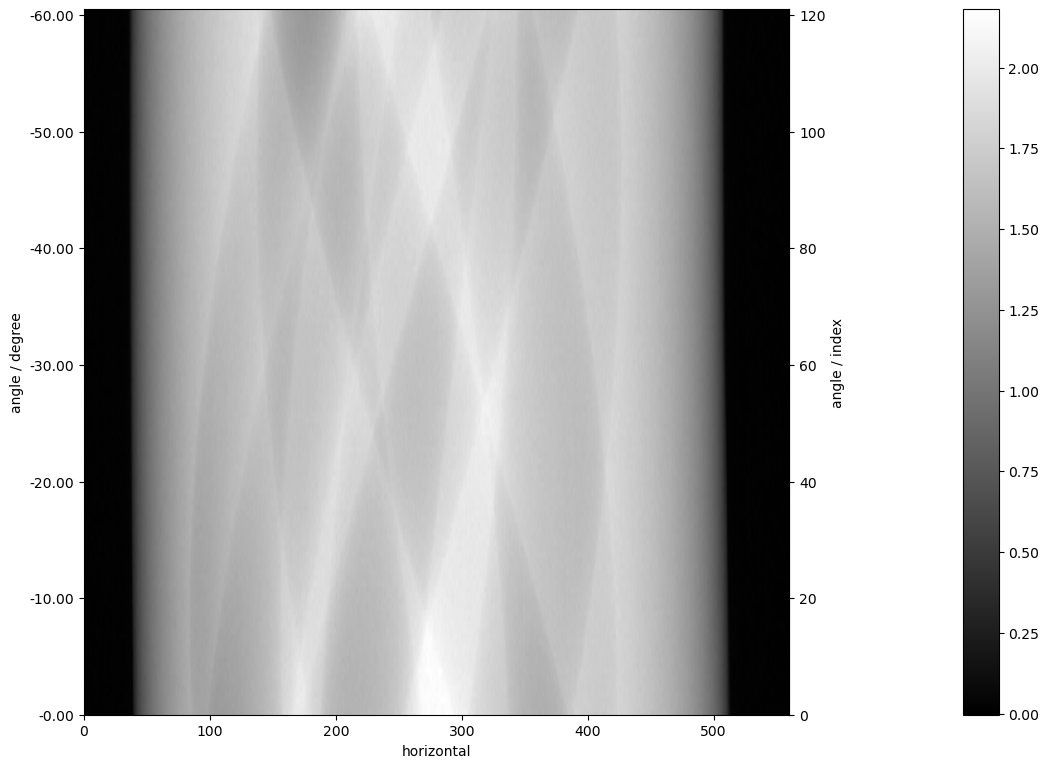

In [7]:
show2D(data)

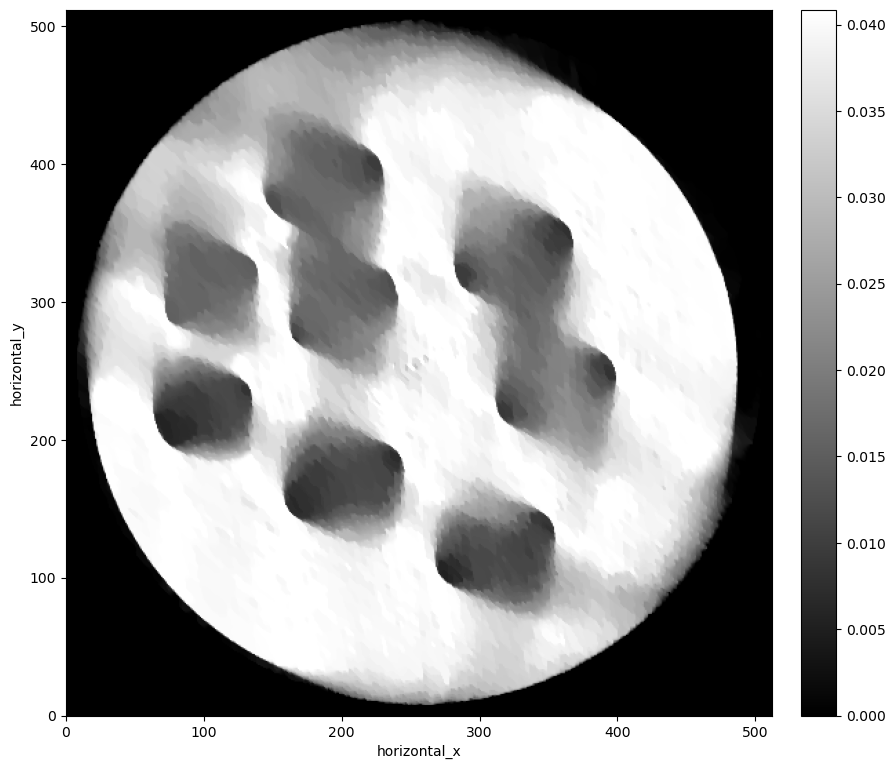

In [8]:
show2D(data_recon)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

from cuqipy_cil.model import FanBeam2DModel
from cuqi.array import CUQIarray
from cuqi.geometry import Image2D
from cuqi.distribution import Gaussian, Gamma, LMRF, JointDistribution
from cuqi.sampler import UGLA, Conjugate, ConjugateApprox, Gibbs

import subprocess
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')



import cuqi
import cuqipy_cil
import cil 
print('cuqi version: ', cuqi.__version__)
print('cuqipy_cil version: ', cuqipy_cil.__version__)
print('cil version: ', cil.__version__)
print('numpy version: ', np.__version__)
!python --version
import scipy 
import matplotlib.pyplot as plt 

Nvidia GPU detected!
cuqi version:  1.1.0
cuqipy_cil version:  0.6.0
cil version:  24.1.0
numpy version:  1.26.4
Python 3.12.5


In [10]:
cuqipy_cil.config.PROJECTION_BACKEND = "astra"
cuqipy_cil.config.PROJECTION_BACKEND_DEVICE = "gpu"


In [11]:
plt.rcParams["figure.dpi"] = 400

/tmp/ipykernel_281581/2100247304.py:17: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
/tmp/ipykernel_281581/2100247304.py:28: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):


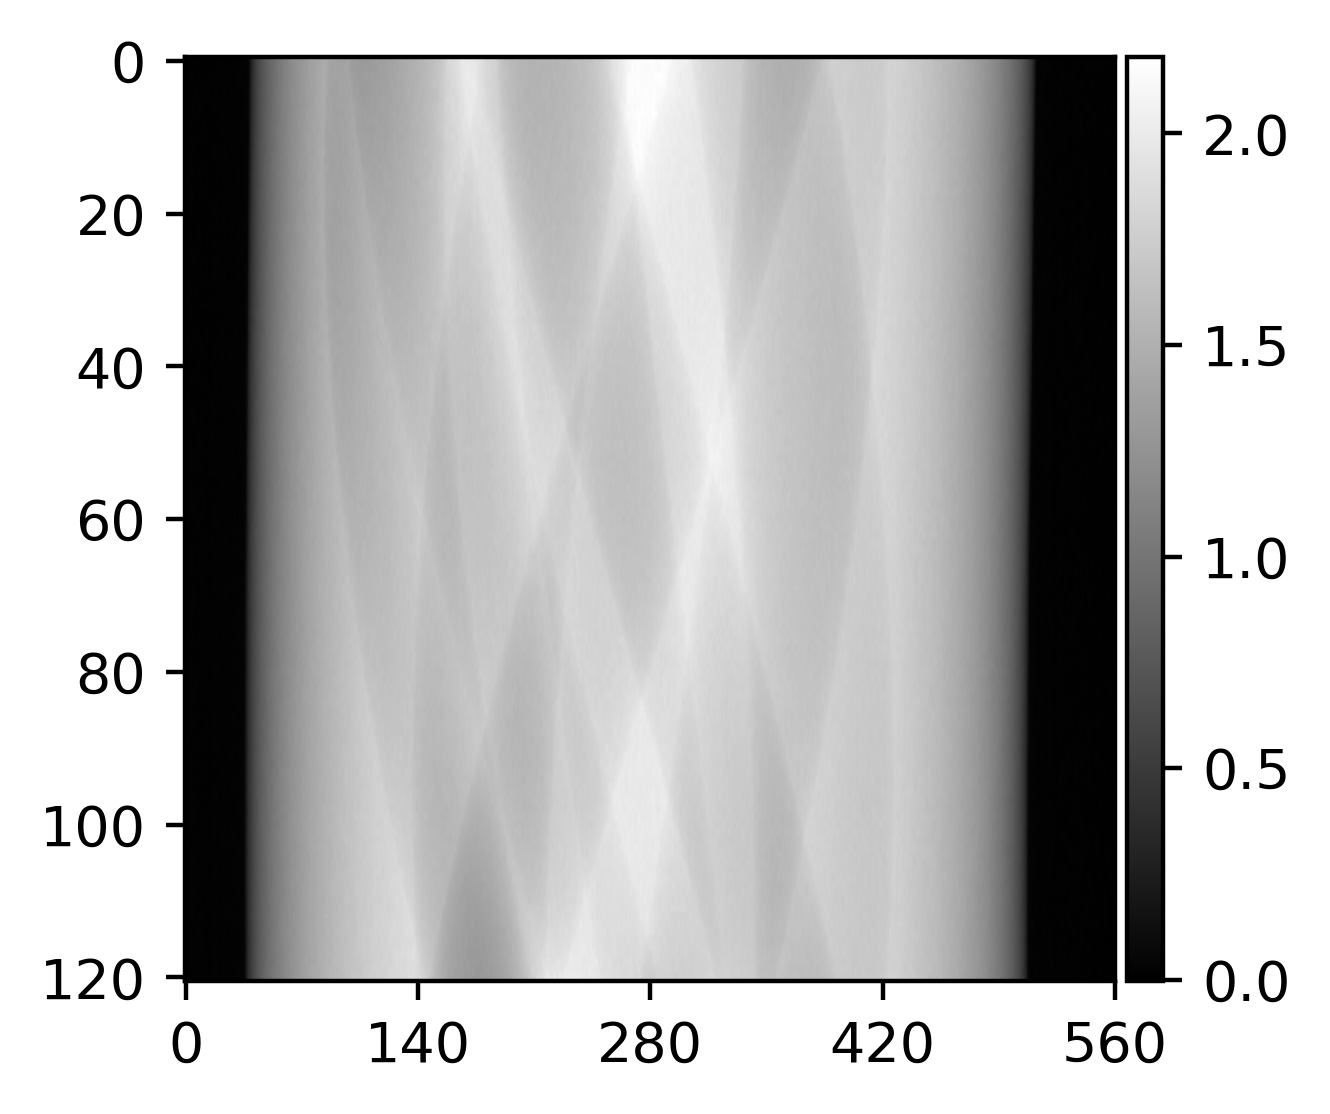

In [12]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

# Acquisition data and geometry parameters
mat = loadmat("/home/bih17925/Margaret_test_notebooks/CUQI-CIL/CIL-HTC2022-Algo5-main/test_data/htc2022_ta_sparse_example.mat")
scan_parameters=mat['CtDataLimited']['parameters']
source_center = scan_parameters['distanceSourceOrigin']
source_detector = scan_parameters['distanceSourceDetector']
pixel_size = scan_parameters['pixelSizePost'] #data is binned
num_dets = scan_parameters['numDetectorsPost']
angles = scan_parameters['angles']
scan_sinogram = mat['CtDataLimited']['sinogram'].astype('float32')
mag=scan_parameters['geometricMagnification']

num_angles = len(angles)


# Subsample sinogram and projection angles
sinogram = scan_sinogram.flatten(order="C")

# Wrap data in CUQIpy geometry
y_obs = CUQIarray(sinogram, is_par=True, geometry=Image2D((num_angles, num_dets)))

# Plot sinogram
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = y_obs.plot(aspect = 'auto')
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,140,280,420,560])


In [13]:
# Define CT model conveniently with cil-plugin
N = 512 # reconstruction dimension NxN
A = FanBeam2DModel(det_count=num_dets, 
                        det_spacing = pixel_size,
                        angles=-angles*(2*np.pi)/360,
                        source_object_dist = source_center,
                        object_detector_dist = source_detector - source_center,
                        domain = (pixel_size*num_dets/mag, pixel_size*num_dets/mag),
                        im_size = (N,N)) 

print(A)

CUQI FanBeam2DModel: Image2D(262144,) -> Image2D(67760,).
    Forward parameters: ['x'].


In [14]:
scan_parameters.keys()

dict_keys(['projectName', 'scanner', 'measurers', 'date', 'dateFormat', 'geometryType', 'distanceSourceOrigin', 'distanceSourceDetector', 'distanceUnit', 'geometricMagnification', 'numberImages', 'angles', 'detector', 'detectorType', 'binning', 'pixelSize', 'exposureTime', 'exposureTimeUnit', 'tube', 'target', 'voltage', 'voltageUnit', 'current', 'currentUnit', 'xRayFilter', 'xRayFilterThickness', 'detectorRows', 'detectorCols', 'freeRayAtDetector', 'binningPost', 'pixelSizePost', 'effectivePixelSizePost', 'numDetectorsPost'])

In [15]:
from cil.utilities.display import show2D, show1D, show_geometry
print(A.image_geometry)
#show_geometry(A.range_geometry)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x512,y512
voxel_size : x0.1622275345830173,y0.1622275345830173
center : x0,y0



In [16]:
# Hyperpriors, prior and data distribution in hierarchical structure
# Note we use lambda functions here, but direct algebraic expressions are part of next release.
d = Gamma(shape=1, rate=1e-4)
s = Gamma(shape=1, rate=1e-4)
y = Gaussian(mean=A, cov=lambda s: 1/s)
x = LMRF(location=np.zeros(A.domain_dim), scale=lambda d: 1/d, geometry=A.domain_geometry)

In [17]:
posterior = JointDistribution(y, x,s,  d)(y = y_obs)

In [18]:
# Samplers for each parameter
sampling_strategy = {
    'd': ConjugateApprox,
    's': Conjugate,
    'x': UGLA}

# Gibbs sampler on p(d,s,x|y=y_obs)
sampler_Gibbs = Gibbs(posterior, sampling_strategy)

In [19]:
# Run sampler
np.random.seed(1000)
st = time.time()
samples_Gibbs = sampler_Gibbs.sample(500,100)
et = time.time()-st
print("Time: {}".format(et))

Warmup 100 / 100
Sample 500 / 500
Time: 1412.967717409134


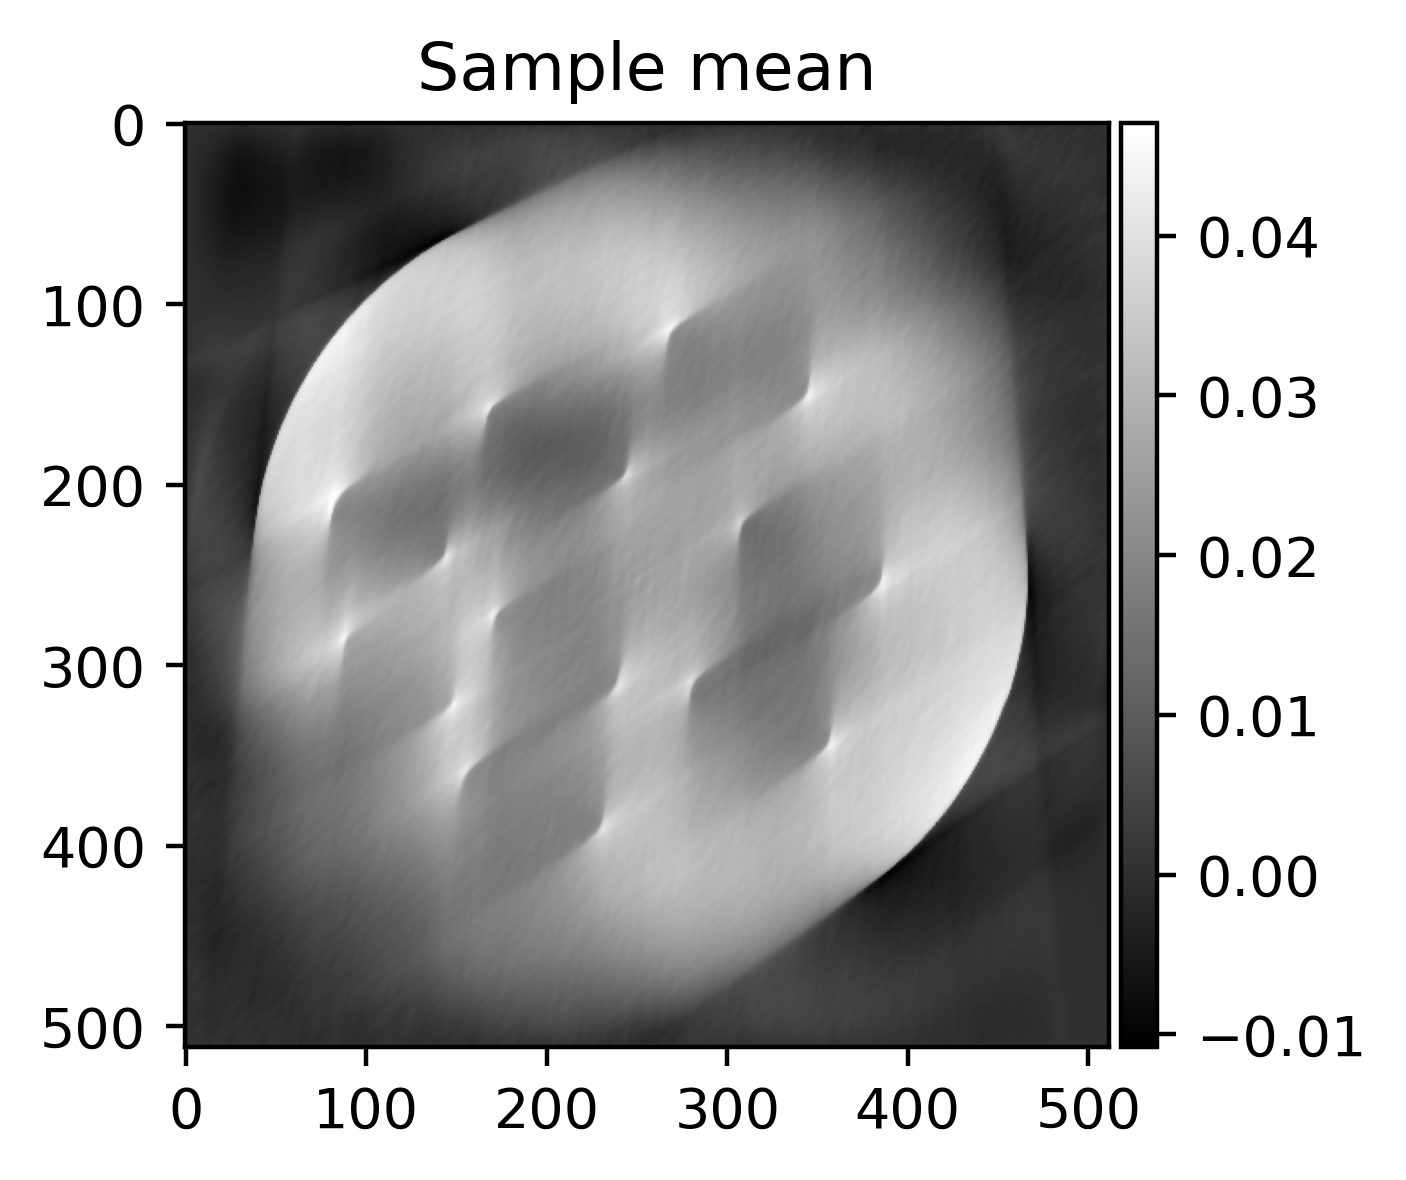

In [20]:
# Plot x mean
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = samples_Gibbs["x"].plot_mean()
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,100,200,300,400,500])
cs[0].axes.set_yticks([0,100,200,300,400,500])


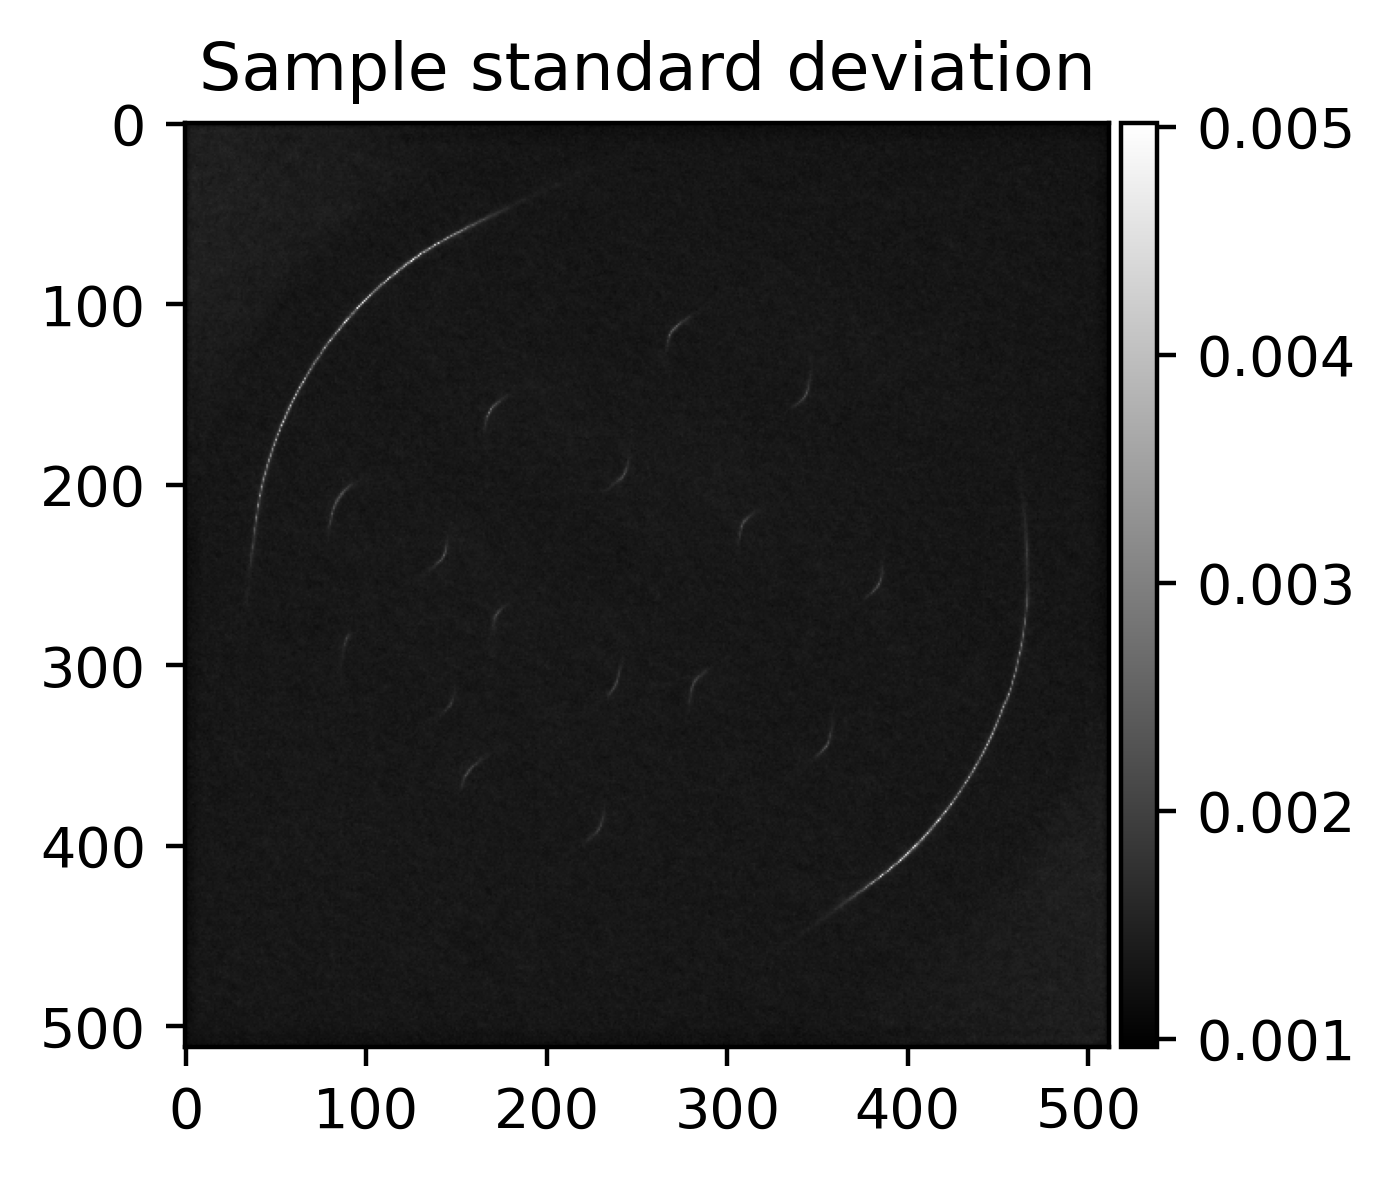

In [21]:
# Plot x std
fig, ax = plt.subplots(1,1, figsize=(3,3))
cs = samples_Gibbs["x"].plot_std()
cax = fig.add_axes([cs[0].axes.get_position().x1+0.01,cs[0].axes.get_position().y0,0.03,cs[0].axes.get_position().height])
cbar = plt.colorbar(cs[0], cax=cax)
cs[0].axes.set_xticks([0,100,200,300,400,500])
cs[0].axes.set_yticks([0,100,200,300,400,500])

/home/bih17925/miniconda3/envs/cuqi-cil/lib/python3.12/site-packages/cuqi/samples/_samples.py:692: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight_layout: plt.tight_layout()
/home/bih17925/miniconda3/envs/cuqi-cil/lib/python3.12/site-packages/cuqi/samples/_samples.py:692: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight_layout: plt.tight_layout()


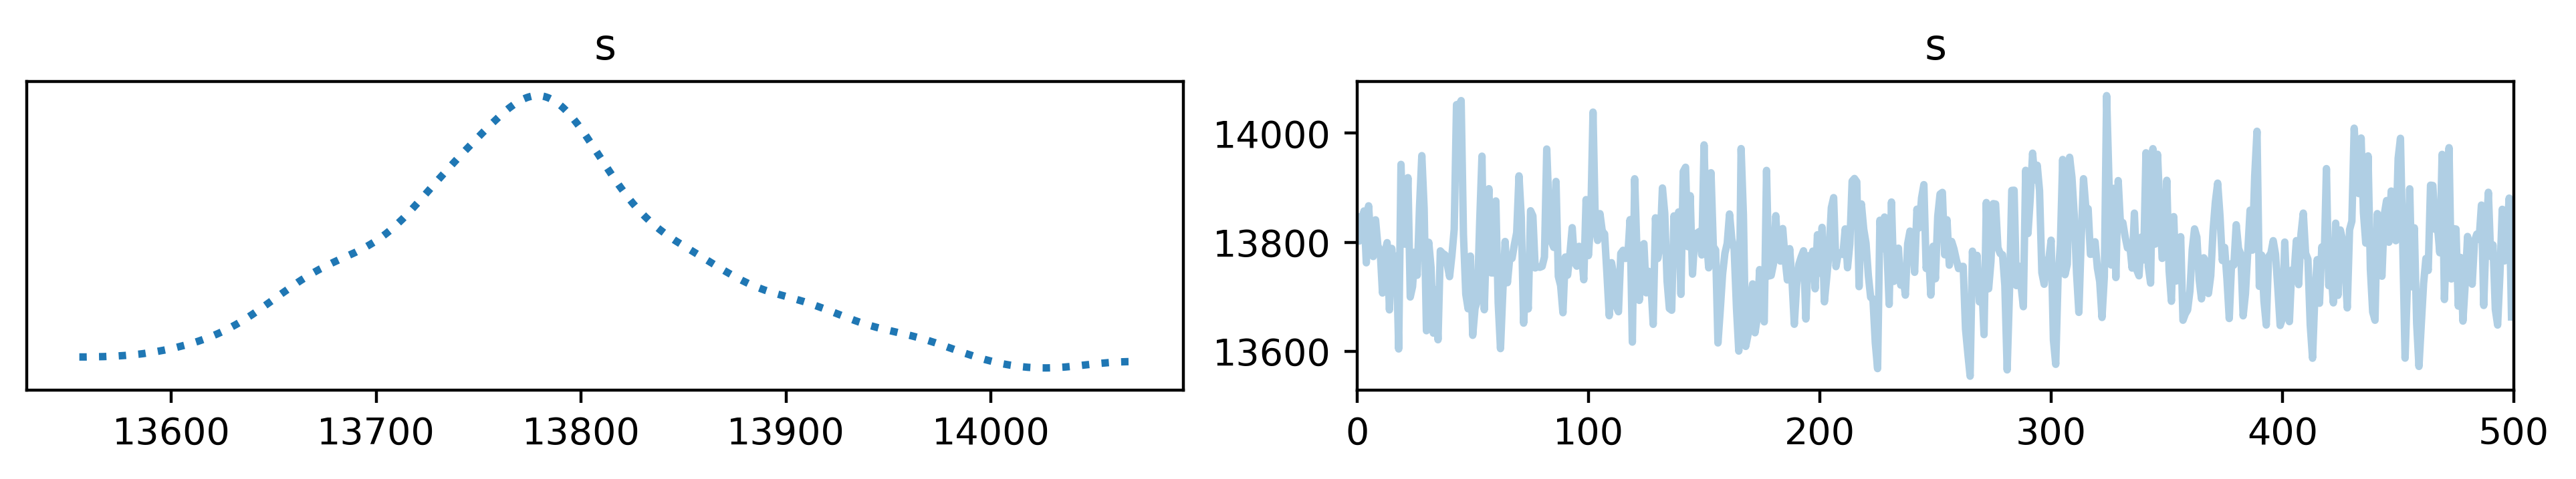

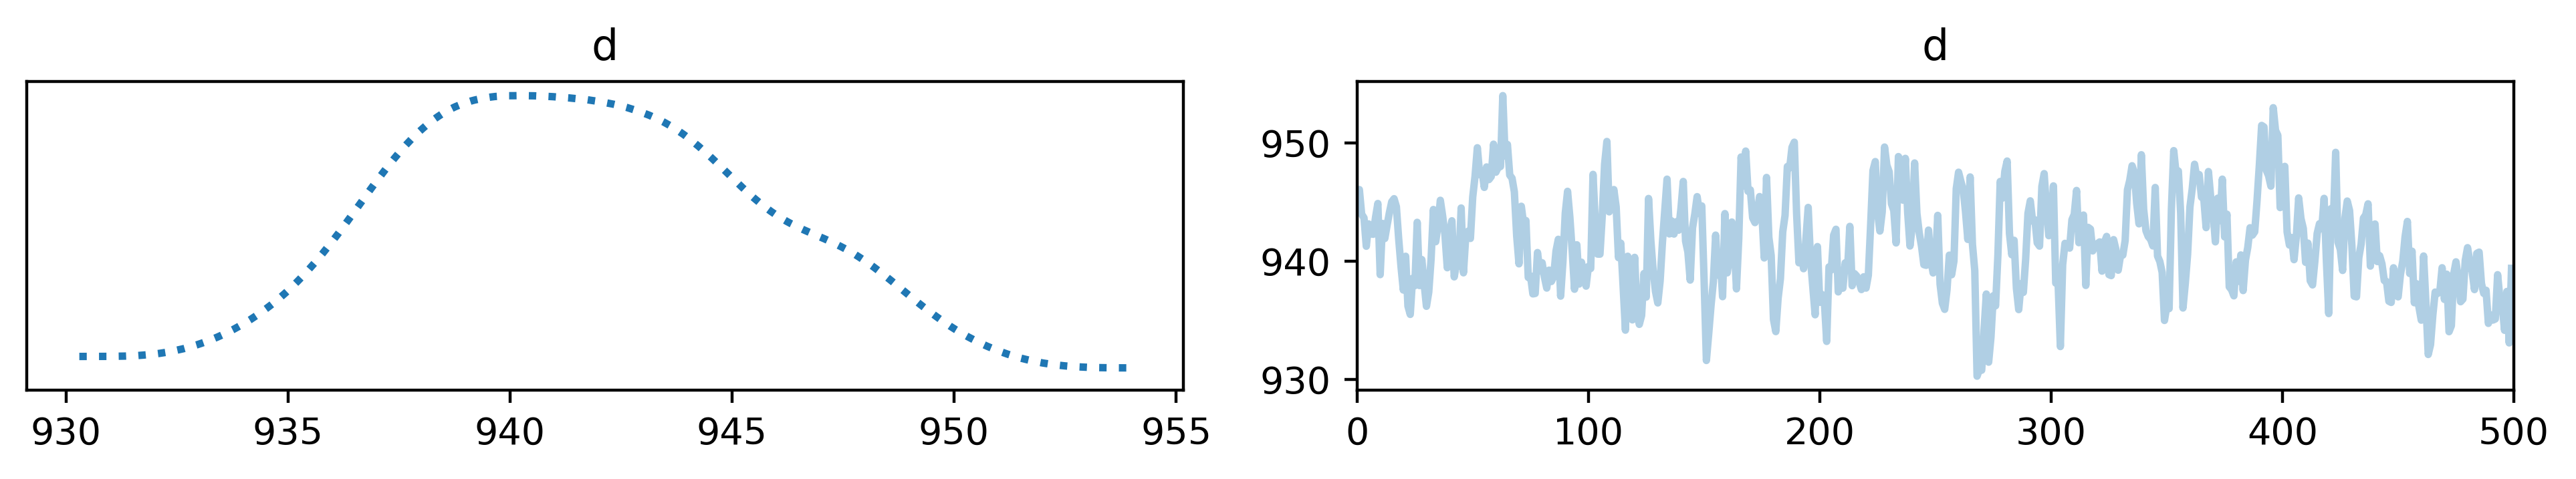

In [22]:
# Plot posterior s samples
fig, axs = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (12,1.5), gridspec_kw = {'wspace': 0.15})
samples_Gibbs["s"].plot_trace(trace_kwargs = {'lw': 2}, plot_kwargs= {'lw': 2}, axes = axs)
axs[0,1].set_xticks([0,100,200,300,400,500])

# Plot posterior d samples
fig, axs = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (12,1.5), gridspec_kw = {'wspace': 0.15})
samples_Gibbs["d"].plot_trace(trace_kwargs = {'lw': 2}, plot_kwargs= {'lw': 2}, axes = axs)
axs[0,1].set_xticks([0,100,200,300,400,500])



In [23]:
samples_Gibbs

{'x': <cuqi.samples._samples.Samples at 0x7f1644f1f710>,
 's': <cuqi.samples._samples.Samples at 0x7f1644f27ec0>,
 'd': <cuqi.samples._samples.Samples at 0x7f1644f2fad0>}